In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, iirnotch, filtfilt

def read_signals(data_dir):
    sigs = []
    titles = []
    for file in os.listdir(data_dir):
        file_path = os.path.join(data_dir, file)
        titles.append(file.split("/")[-1])
        
        with open(file_path, "r") as f:
            lines = f.readlines()
            signal = []
            for i, l in enumerate(lines):
                try:
                    signal.append(int(l.split(',')[1]))
                except:
                    print(i)
            sigs.append(np.array(signal))
    return sigs, titles

def visualize_sigs(signals, titles):
    fig, ax = plt.subplots(len(signals), 1, figsize=(20,10))
    for i in range(len(signals)):
        ax[i].plot(signals[i])
        ax[i].set_title(titles[i])
    plt.tight_layout()

def denoise_TKEO(signal):
    tkeo_sig = (np.square(signal[1:-1]) - signal[:-2] * signal[2:])
    return tkeo_sig

def get_baseline(signal, k=3, t=5, fs=1000):
    baseline_end = t * fs
    mean = np.mean(signal[:baseline_end])
    return mean

def get_threshold(signal, k, t=5, fs=1000):
    baseline_end = t * fs
    mean = np.mean(signal[:baseline_end])
    std = np.std(signal[:baseline_end])
    thresh = mean + std*k
    return thresh

def remove_baseline(signal, mean):
    return signal - mean

def binarize_signal(signal, thresh):
    return signal > thresh

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], analog=False, btype='band', output='sos')
    return sos

def butter_bandpass_filter(data, lowcut=20, highcut=450, fs=1000, order=4):
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sosfilt(sos, data)
    return y
    
def notch_filter(data, f=50, Q=30, fs=1000):
    b, a = iirnotch(f, Q, fs)
    y = filtfilt(b, a, data)
    return y

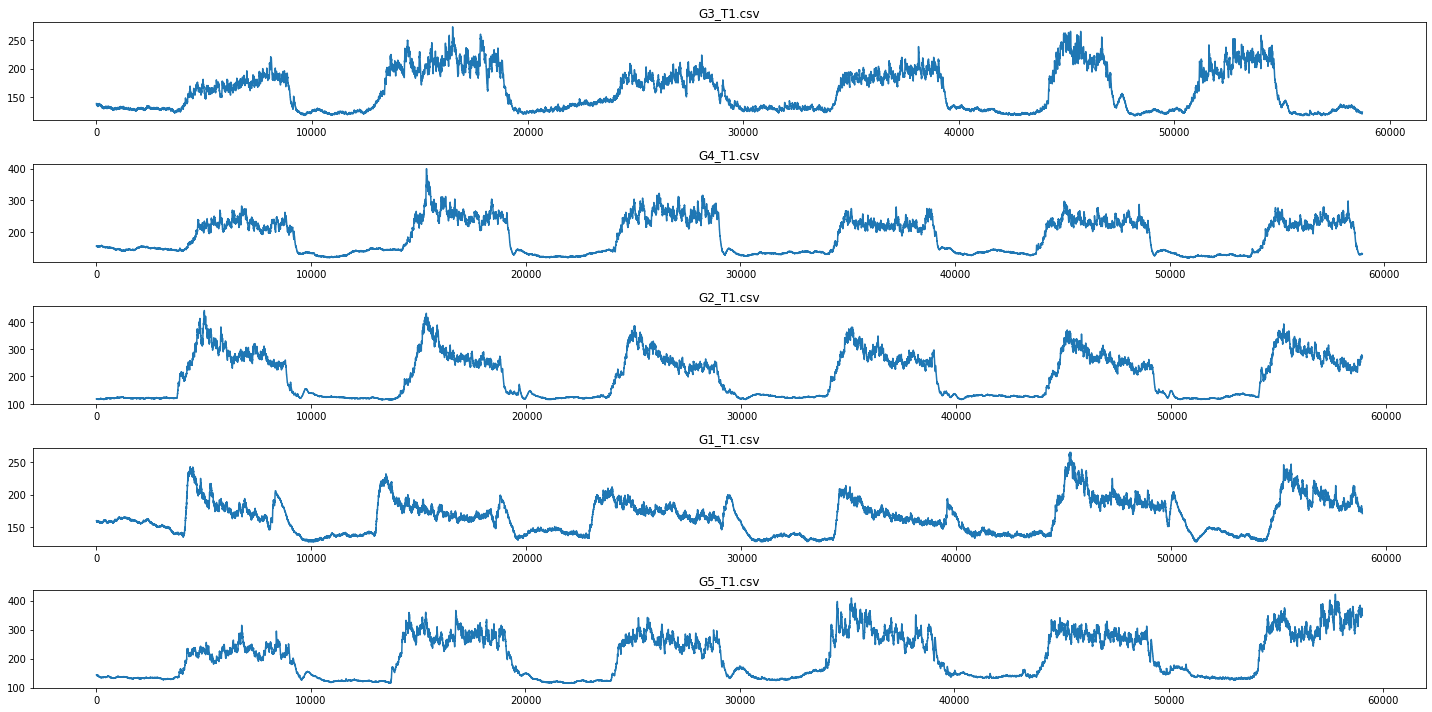

In [9]:
sigs, titles = read_signals("collected-samples/lobna-signals")
visualize_sigs(sigs, titles)

# Filtering
Filter signals using 4th order butterworth bandpass filter between 20-450Hz and a notch filter at 50hz

In [20]:
filtered_sigs = [butter_bandpass_filter(sig) for sig in sigs]
filtered_sigs = [notch_filter(sig) for sig in sigs]

# Baseline Removal
To remove noise, we take the average of the first 5s (resting period) as our baseline, and subtract it from our signal

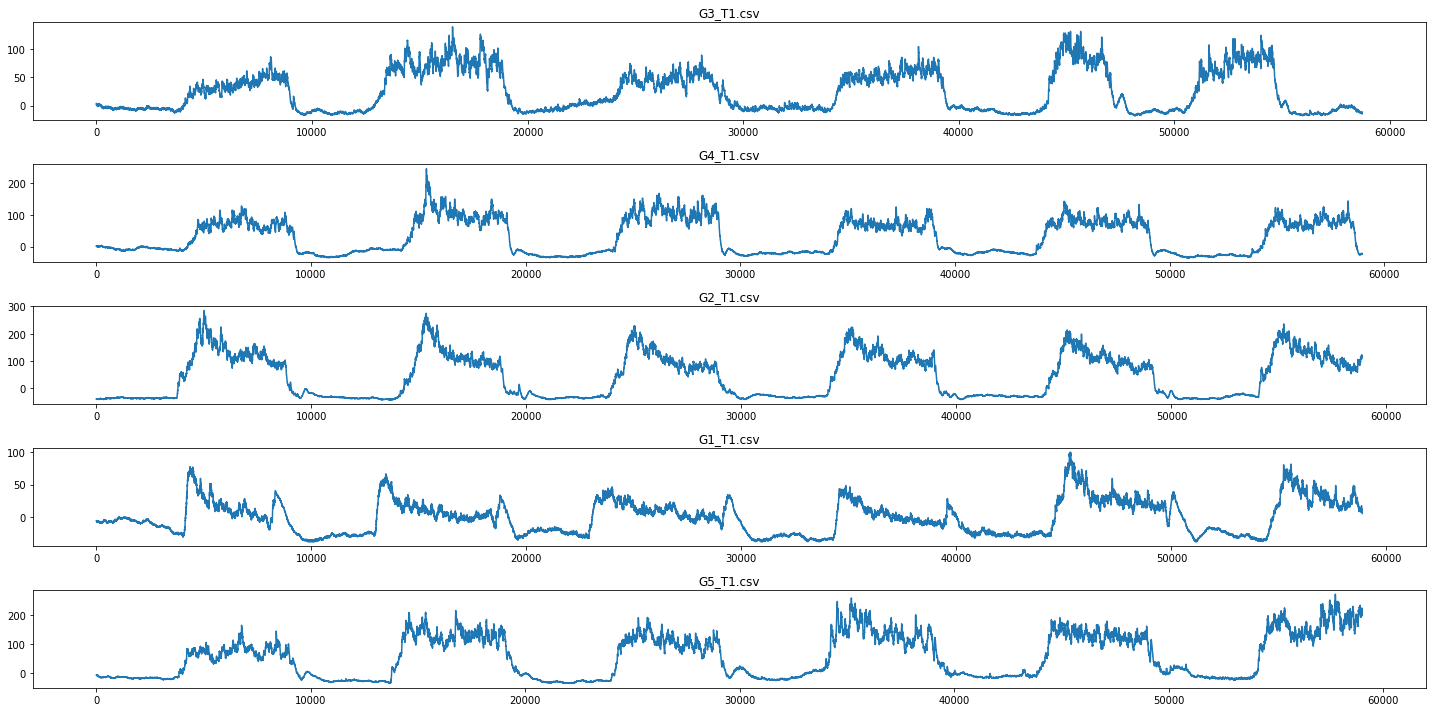

In [111]:
baselines = [get_baseline(sig) for sig in sigs]
baseline_removed_sigs = [remove_baseline(sig, bl) for sig, bl in zip(sigs, baselines)]

visualize_sigs(baseline_removed_sigs, titles)

# Thresholding
For data labeling, we get 2 thresholds. If we exceed the first (signal mean + std), we mark the beginning of gesture. If we then go below the second (signal mean), we mark the end of the gesture.

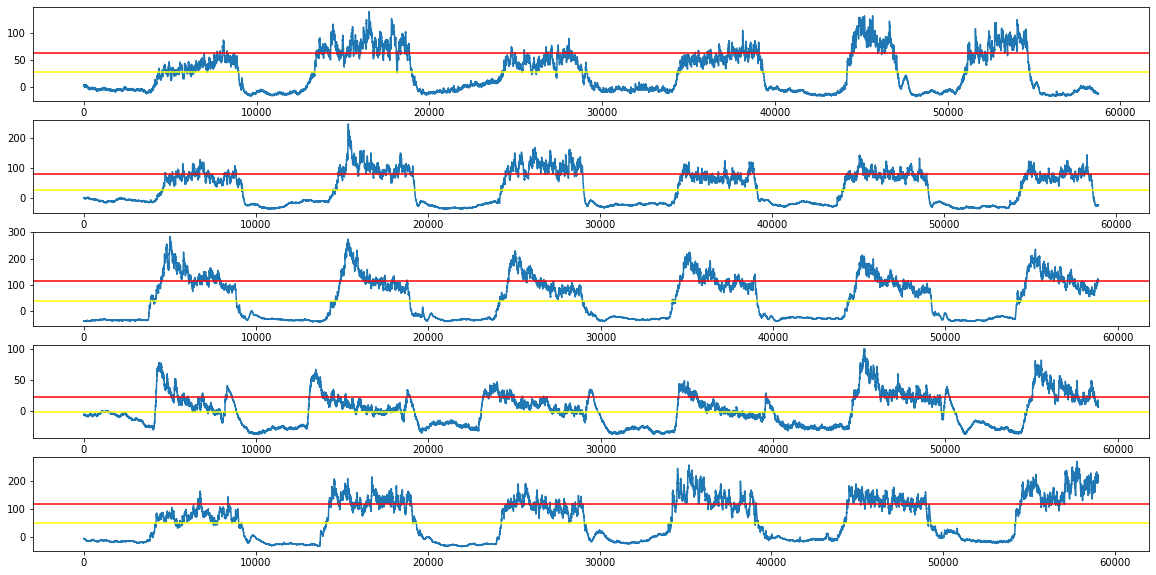

In [112]:
thresh_1 = [get_threshold(s, k=1, t=55) for s in baseline_removed_sigs]
thresh_2 = [get_threshold(s, k=0, t=55) for s in baseline_removed_sigs]

fig, ax = plt.subplots(5, 1, figsize = (20,10))

for i in range(5):
    ax[i].plot(baseline_removed_sigs[i])
    ax[i].axhline(thresh_1[i], color='red')
    ax[i].axhline(thresh_2[i], color='yellow')

# TKEO  

We can see above that some activity regions are below the threshold. As an alternative, we use TKEO operator which is defined as:



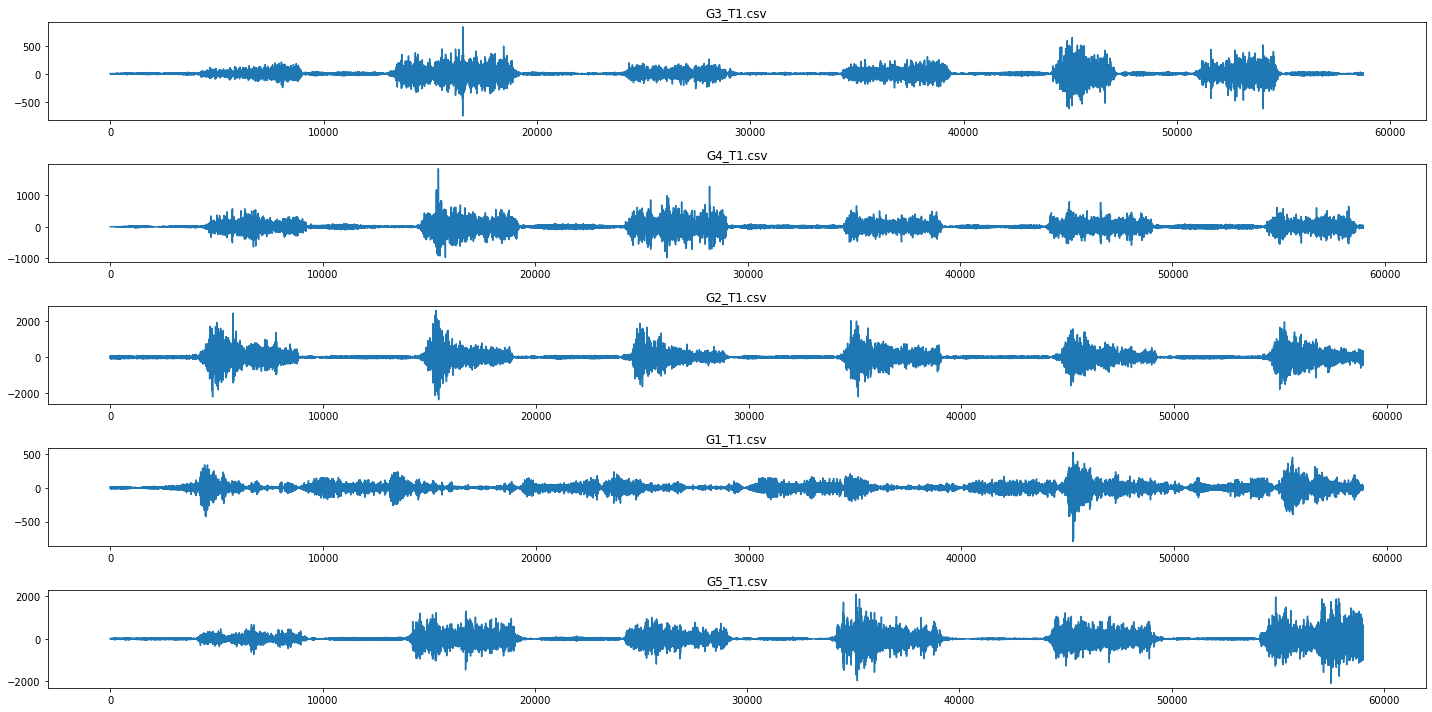

In [113]:
tkeo_sigs = [denoise_TKEO(sig) for sig in baseline_removed_sigs]
visualize_sigs(tkeo_sigs, titles)

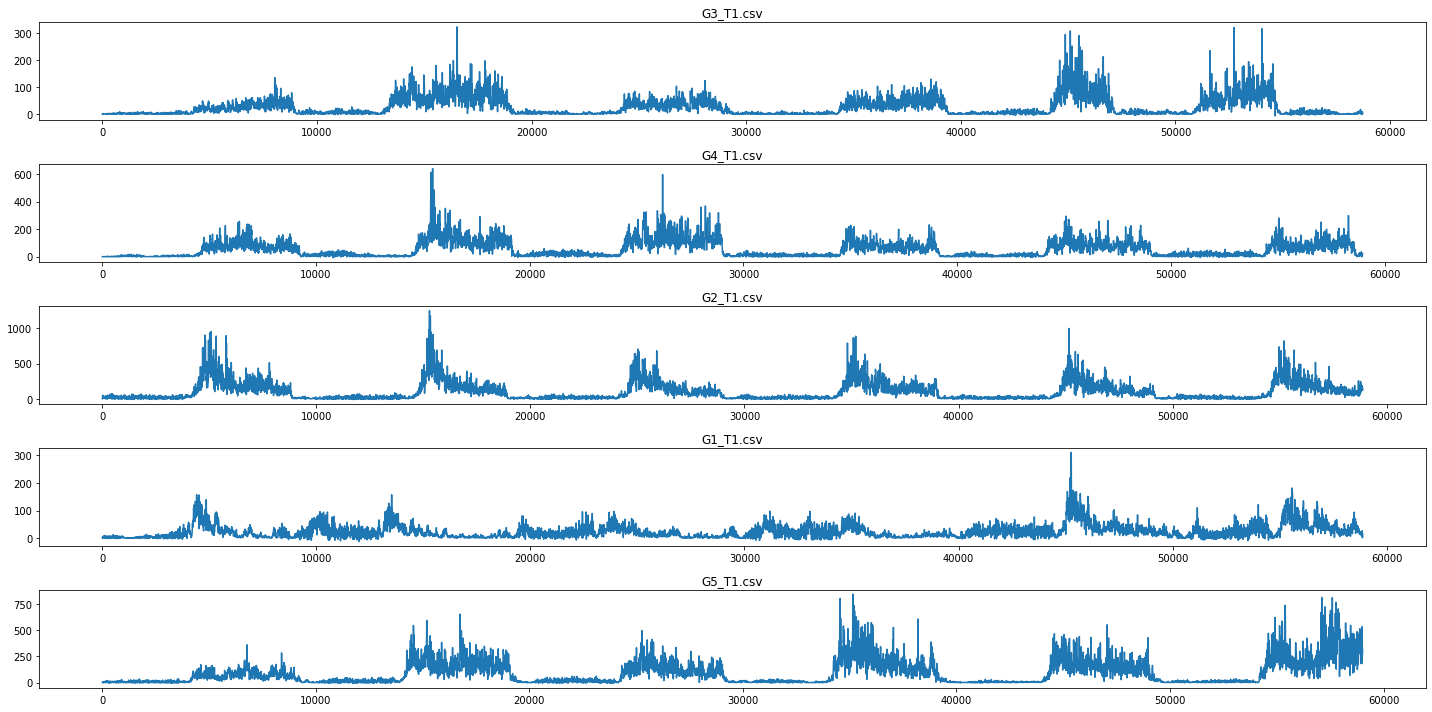

In [114]:
filtered_sig = [butter_lowpass_filter(np.abs(sig), 50, 1000, order=5) for sig in tkeo_sigs]
visualize_sigs(filtered_sig, titles)

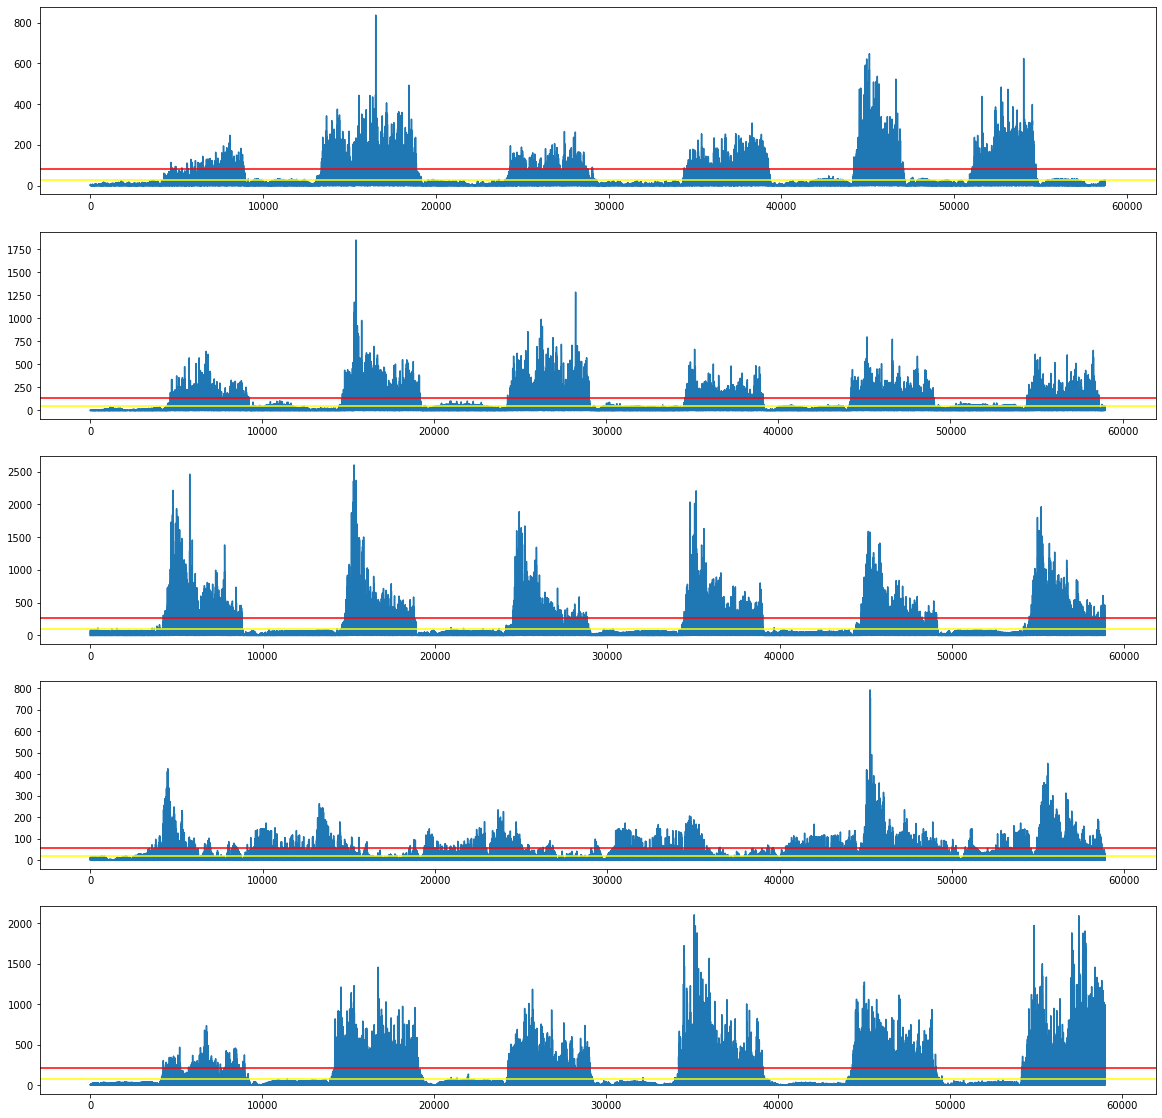

In [38]:
thresh_1 = [get_threshold(np.abs(s), k=1, t=55) for s in tkeo_sigs]
thresh_2 = [get_threshold(np.abs(s), k=0, t=55) for s in tkeo_sigs]

fig, ax = plt.subplots(5, 1, figsize = (20,20))
for i in range(5):
    ax[i].plot(np.abs(tkeo_sigs[i]))
    ax[i].axhline(thresh_1[i], color='red')
    ax[i].axhline(thresh_2[i], color='yellow')

In [ ]:
filtered_sig = [butter_lowpass_filter(np.abs(sig), 50, 1000, order=5) for sig in baseline_removed_sigs]
visualize_sigs(filtered_sig, titles)

# Frequency transformation

'plt.subplot(212)\nplt.plot(fft_fre, fft_wave.imag,label="Imaginary part")\nplt.legend(loc=1)\nplt.xlabel("frequency (Hz)")\n\nplt.show()'

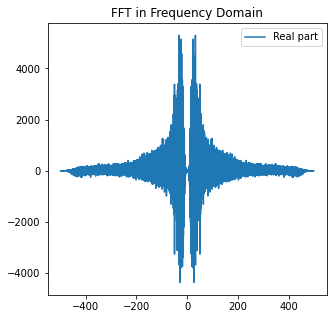

In [9]:
n = len(sigs[0])
fft_wave = np.fft.fft(butter_bandpass_filter(sigs[0]))

fft_fre = np.fft.fftfreq(n=fft_wave.size, d=1/1000)

plt.figure(figsize=(5, 5))
plt.subplot(111)
plt.plot(fft_fre, fft_wave.real, label="Real part")
plt.legend(loc=1)
plt.title("FFT in Frequency Domain")

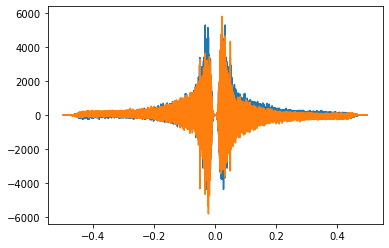

In [62]:
sp = np.fft.fft(butter_bandpass_filter(sigs[0]))
freq = np.fft.fftfreq(len(sigs[0]))
plt.plot(freq, sp.real, freq, sp.imag)
plt.show()

/home/amr/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


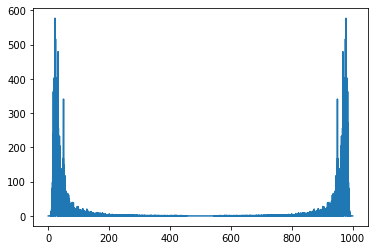

In [68]:
n = len(sigs[0])

fhat = np.fft.fft(butter_bandpass_filter(sigs[0]), n)                     
PSD = fhat * np.conj(fhat) / n
freqs = (1/(0.001*n)) * np.arange(n) 

plt.plot(freqs, PSD)
plt.show()

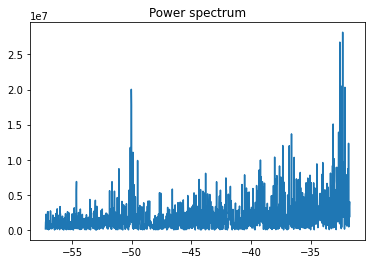

In [105]:
fs = 1000

time = np.arange(len(sigs[0])) / fs
freqs = np.fft.fftfreq(time.size, 1/fs)
idx = np.argsort(freqs)

ps = np.abs(np.fft.fft(butter_bandpass_filter(sigs[0])))**2
plt.figure()
plt.plot(freqs[idx[26000:27500]], ps[idx[26000:27500]])
plt.title('Power spectrum');

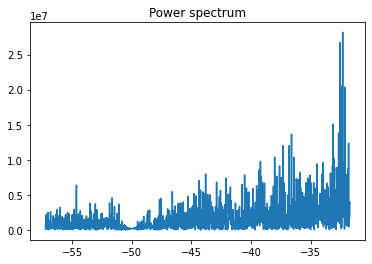

In [10]:
fs = 1000

time = np.arange(len(sigs[0])) / fs
freqs = np.fft.fftfreq(time.size, 1/fs)
idx = np.argsort(freqs)

ps = np.abs(np.fft.fft(notch_filter(butter_bandpass_filter(sigs[0]))))**2
plt.figure()
plt.plot(freqs[idx[26000:27500]], ps[idx[26000:27500]])
plt.title('Power spectrum');